# Imprtant Library

In [2]:
import pandas as pd
import numpy as np
from datasets import load_dataset, load_metric
from transformers import AutoTokenizer, DataCollatorForTokenClassification, TFAutoModelForTokenClassification, pipeline, logging
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers.schedules import PolynomialDecay
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import spacy
from spacy import displacy
import matplotlib.pyplot as plt

logging.set_verbosity_error()


# Load Dataset

In [3]:
# Load CoNLL-2003 Dataset
data = load_dataset('conll2003')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [4]:
# Load Tokenizer and Pretrained BERT Model
checkpoint = 'bert-base-cased'
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

# Preprocessing

In [5]:
# Preprocessing Function
label_names = data["train"].features['ner_tags'].feature.names

begin2inside = {1: 2, 3: 4, 5: 6, 7: 8}

def align_targets(labels, word_ids):
    aligned_labels = []
    last_word = None
    for word in word_ids:
        if word is None:
            label = -100
        elif word != last_word:
            label = labels[word]
        else:
            label = labels[word]
            if label in begin2inside:
                label = begin2inside[label]
        aligned_labels.append(label)
        last_word = word
    return aligned_labels

In [6]:
def tokenize_fn(batch):
    tokenized_inputs = tokenizer(
        batch['tokens'], truncation=True, is_split_into_words=True
    )
    labels_batch = batch['ner_tags']
    aligned_labels_batch = []
    for i, labels in enumerate(labels_batch):
        word_ids = tokenized_inputs.word_ids(i)
        aligned_labels_batch.append(align_targets(labels, word_ids))
    tokenized_inputs['labels'] = aligned_labels_batch
    return tokenized_inputs

tokenized_datasets = data.map(
    tokenize_fn,
    batched=True,
    remove_columns=data["train"].column_names,
)

data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

Map:   0%|          | 0/14041 [00:00<?, ? examples/s]

Map:   0%|          | 0/3250 [00:00<?, ? examples/s]

Map:   0%|          | 0/3453 [00:00<?, ? examples/s]

# Prepare Datasets 

In [7]:
# Training
train_dataset = tokenized_datasets["train"].to_tf_dataset(
    columns=['input_ids', 'token_type_ids', 'attention_mask'],
    label_cols=["labels"],
    shuffle=True,
    collate_fn=data_collator,
    batch_size=32)

# Validation
validation_dataset = tokenized_datasets["validation"].to_tf_dataset(
    columns=['input_ids', 'token_type_ids', 'attention_mask'],
    label_cols=["labels"],
    shuffle=True,
    collate_fn=data_collator,
    batch_size=32)

# Testing
test_dataset = tokenized_datasets["test"].to_tf_dataset(
    columns=['input_ids', 'token_type_ids', 'attention_mask'],
    label_cols=["labels"],
    collate_fn=data_collator,
    batch_size=1
)

/usr/local/lib/python3.10/dist-packages/datasets/arrow_dataset.py:410: FutureWarning: The output of `to_tf_dataset` will change when a passing single element list for `labels` or `columns` in the next datasets version. To return a tuple structure rather than dict, pass a single string.
Old behaviour: columns=['a'], labels=['labels'] -> (tf.Tensor, tf.Tensor)  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor)  
New behaviour: columns=['a'],labels=['labels'] -> ({'a': tf.Tensor}, {'labels': tf.Tensor})  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor) 
  warnings.warn(


In [8]:
# Build and Compile the Model
id2label = {k: v for k, v in enumerate(label_names)}
label2id = {v: k for k, v in id2label.items()}

model = TFAutoModelForTokenClassification.from_pretrained(
    checkpoint,
    id2label=id2label,
    label2id=label2id,
)


model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

In [9]:
# Unfreeze more layers for fine-tuning
for layer in model.layers[-5:]:  # Adjust the number of layers to unfreeze
    layer.trainable = True

In [10]:
# Define Hyperparameters
learning_rate = 3e-5
num_epochs = 10
batch_size = 8
weight_decay = 0.005

In [13]:
# Update Learning Rate Scheduler and Optimizer
num_train_steps = len(train_dataset) * num_epochs
lr_scheduler = PolynomialDecay(initial_learning_rate=learning_rate, end_learning_rate=0.0, decay_steps=num_train_steps)
opt = 'Adam' 

# Define Loss 
loss = SparseCategoricalCrossentropy(from_logits=True, ignore_class=[-100])

model.compile(optimizer=opt, loss=loss, metrics=['accuracy'])

In [14]:
# Train Model 
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=num_epochs
)

Epoch 1/10


Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
439/439 [==============================] - 299s 424ms/step - loss: 1.0593 - accuracy: 0.2695 - val_loss: 1.0359 - val_accuracy: 0.2581
Epoch 2/10
439/439 [==============================] - 178s 406ms/step - loss: 1.0301 - accuracy: 0.2732 - val_loss: 1.0343 - val_accuracy: 0.2614
Epoch 3/10
439/439 [==============================] - 179s 409ms/step - loss: 1.0276 - accuracy: 0.2716 - val_loss: 1.0296 - val_accuracy: 0.2573
Epoch 4/10
439/439 [==============================] - 179s 407ms/step - loss: 1.0280 - accuracy: 0.2727 - val_loss: 1.0278 - val_accuracy: 0.2591
Epoch 5/10
439/439 [==============================] - 179s 407ms/step - loss: 1.0270 - accuracy: 0.2720 - val_loss: 1.0247 - val_accuracy: 0.2625
Epoch 6/10
439/439 [==============================] - 178s 406ms/step - loss: 1.0263 - accuracy: 0.2731 - val_loss: 1.0275 - val_accuracy: 0.25

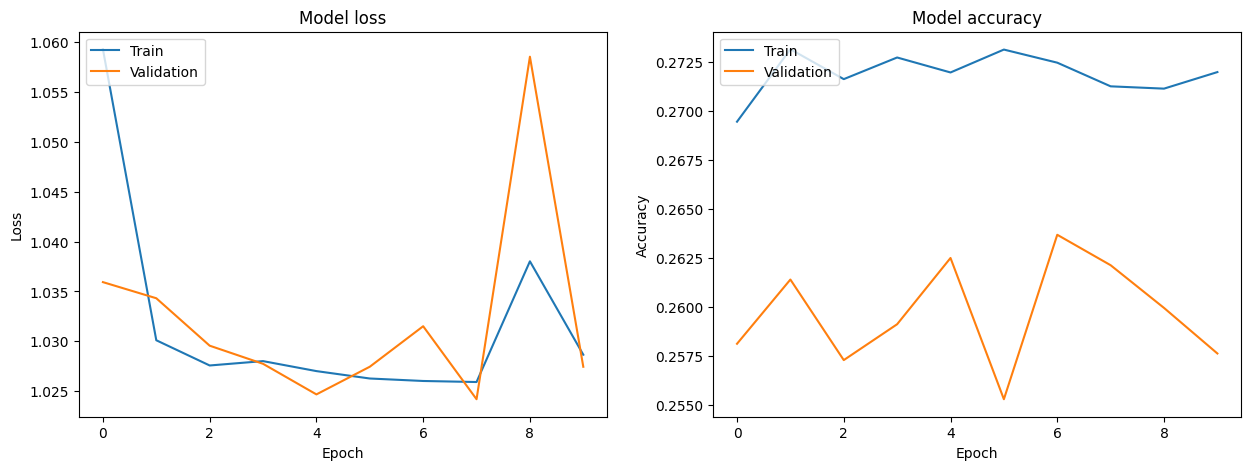

In [15]:

# Visualize Training Loss and Accuracy
def plot_metrics(history):
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))

    # Plot training & validation loss values
    axs[0].plot(history.history['loss'])
    axs[0].plot(history.history['val_loss'])
    axs[0].set_title('Model loss')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Loss')
    axs[0].legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation accuracy values
    axs[1].plot(history.history['accuracy'])
    axs[1].plot(history.history['val_accuracy'])
    axs[1].set_title('Model accuracy')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend(['Train', 'Validation'], loc='upper left')

    plt.show()

plot_metrics(history)

In [16]:
# Evaluate the Model
evaluation = model.evaluate(test_dataset)
print(f"Test Loss: {evaluation[0]}")
print(f"Test Accuracy: {evaluation[1]}")

3453/3453 [==============================] - 129s 37ms/step - loss: 1.1287 - accuracy: 0.6811
Test Loss: 1.1286693811416626
Test Accuracy: 0.6810721158981323


In [17]:
# Compute Predictions and True Labels
preds = model.predict(test_dataset).logits
true_labels = tokenized_datasets['test']['labels']

3453/3453 [==============================] - 124s 33ms/step


In [18]:
# Convert Predictions and Labels to Strings
str_labels = [
    [label_names[t] for t in label if t != -100] for label in true_labels
]

str_preds = []
for i, j in zip([np.argmax(i, axis=-1) for i in preds.numpy()], true_labels):
    in_bucket = []
    for p, t in zip(i, j):
        if t != -100:
            in_bucket.append(label_names[p])
    str_preds.append(in_bucket)

In [19]:
# Compute and Display Metrics
metric = load_metric("seqeval")
the_metrics = metric.compute(predictions=str_preds, references=str_labels)

<ipython-input-19-0e22f5e944dd>:2: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("seqeval")


The repository for seqeval contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/seqeval.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [24]:
# Metrics
overall_metrics = {
    'precision': the_metrics['overall_precision'],
    'recall': the_metrics['overall_recall'],
    'f1': the_metrics['overall_f1'],
    'accuracy': the_metrics['overall_accuracy']
}

In [25]:
# Entity-specific Metrics
entity_metrics = {entity: {
    'precision': the_metrics[entity]['precision'],
    'recall': the_metrics[entity]['recall'],
    'f1': the_metrics[entity]['f1']
} for entity in ['LOC', 'MISC', 'ORG', 'PER']}
print("Overall Metrics:")
for key, value in overall_metrics.items():
    print(f"{key}: {value:.4f}")



Overall Metrics:
precision: 0.0000
recall: 0.0000
f1: 0.0000
accuracy: 0.7552


In [22]:
# Save the Model and Tokenizer
model.save_pretrained('ner_model')
tokenizer.save_pretrained('ner_tokenizer')

('ner_tokenizer/tokenizer_config.json',
 'ner_tokenizer/special_tokens_map.json',
 'ner_tokenizer/vocab.txt',
 'ner_tokenizer/added_tokens.json',
 'ner_tokenizer/tokenizer.json')

In [26]:
# Convert Predictions and Labels to Strings
str_labels = [
    [label_names[t] for t in label if t != -100] for label in tokenized_datasets['test']['labels']
]

str_preds = []
for i, j in zip([np.argmax(i, axis=-1) for i in preds.numpy()], tokenized_datasets['test']['labels']):
    in_bucket = []
    for p, t in zip(i, j):
        if t != -100:
            in_bucket.append(label_names[p])
    str_preds.append(in_bucket)


In [30]:
# Compute Metrics
metric = load_metric("seqeval")
#the_metrics = metric.compute(predictions=str_preds, references=str_labels)
the_metrics = metric.compute(predictions=str_preds, references=str_labels, zero_division=0)
# Display Metrics
overall_metrics = pd.DataFrame({
    'precision': [the_metrics['overall_precision']],
    'recall': [the_metrics['overall_recall']],
    'f1': [the_metrics['overall_f1']],
    'accuracy': [the_metrics['overall_accuracy']],
})

display(overall_metrics)

,precision,recall,f1,accuracy
0,0.0,0.0,0.0,0.755188


In [ ]:
# Predict and Visualize Named Entities
clf = pipeline('token-classification', model='ner_model', tokenizer='ner_tokenizer', aggregation_strategy='simple')

df = pd.read_csv('Data/bbc_data.csv')
sample_texts = df.sample(3, random_state=2024)['data'].values

def visualize_ner(text):
    result = clf(text)
    for entity in result:
        entity['label'] = entity.pop('entity_group') # Fix here
        for key in ['score', 'word']:
            entity.pop(key, None)
    return displacy.render({"text": text, "ents": result, "title": None}, manual=True, style="ent")

for i, text in enumerate(sample_texts):
    print(f"## Article {i+1}")
    visualize_ner(text)